In [1]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=188ef17d84360aac55ab0195f1d41ae09de04d42791989bb473d4981a359d388
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


MOUNT THE DRIVE AND LOAD THE DATASET

In [2]:
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

import numpy as np

In [4]:
#general variables
n_epochs=5
cycle_lambda = 10.
root_data = "lch_database"

In [5]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
'archive(4).zip'
'Copy of cycleGAN_CH.ipynb'
 CycleGAN.ipynb
 cycleGAN_patches.ipynb
 for_patches.jpg
 for_test_2.png
 for_test.png
 lch_database/
 lch_harmonies_dataset/
 LCH_UTILS.ipynb
 Models/
 notebooks_utils/
 not_so_straight_and_narrow_by_organicvision_degbboy-fullview.jpg
 result_analog.png
 winter_summer_dataset/


In [7]:
#import kmeans harmony classification function
import sys
sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN/Models/model_evaluation/')
from colorExtraction import getMainColors_kmeans
from harmony import getHarmonyType

#SET WHICH MODEL TO TEST

In [8]:
model_type = "rect"

#MODELS

on a besoin des classes des modèles pour charger le type de modèle que j'ai enregistré. Si on veut faire sans la classe, on peut enregistrer une autre version mais ça prend bcp de place (j'ai vu jusqu'à 256Mo)

In [9]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [10]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [11]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [12]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,2,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [13]:
%ls lch_database/

data_dir = "lch_database"

analog_lch/  comp_lch/  mono_lch/  rectangle_lch/  triad_lch/  unknown_lch/


#loading and testing

(pour choisir l'image à donner en rgb, changer l'input de Image.open())

In [14]:
the_model = Generator(n_residuals=3,num_features=64)
the_model.load_state_dict(torch.load("Models/"+model_type))
the_model = the_model.to(torch.device("cuda:0"))

In [34]:
def open_image(class_dir,image_name):
  img = np.array(Image.open(data_dir+"/"+class_dir+"/"+image_name))
  img = torch.Tensor(np.moveaxis(img,-1,0)).to(torch.device("cuda:0"))/255.
  return img

#takes a CPU tensor of shape (3,_,_) and returns a matplotlib-printable image
def process_image(model,image):
  genImg = model(image)
  genImg = np.array(torch.cat([image[0,:,:].reshape((1,256,256)),genImg],axis=0).cpu().detach())
  #get the hue between 0 and 360 and the others multiplied by 255
  genImg[:2,:,:]*=255.
  genImg[2,:,:]*=360
  return np.moveaxis(genImg,0,-1)

#takes a (_,_,3) image
def predict_harmony(image):
  bins_kmeans = getMainColors_kmeans(image)
  if bins_kmeans is not None:
    return getHarmonyType(bins_kmeans)
  else:
    return None

In [35]:
allResults = []


#make a histogram of where the generated images fall

#for each harmony type
for dir in os.listdir(data_dir):
  i=0
  results = {"mono":0,"analog":0,"comp":0,"triad":0,"rectangle":0}
  #get 20 random images
  filenames = os.listdir(data_dir+"/"+dir+"/")
  print("testing type",dir)
  for i in range(20):
    idx = np.random.randint(len(filenames))
    img = open_image(dir,filenames[idx])
    img = process_image(the_model,img)
    harm = predict_harmony(img)
    if harm is not None:
      results[harm]+=1
    if i==19:
      print("did 20 images")
  allResults.append(results)

testing type comp_lch
did 20 images
testing type triad_lch
did 20 images
testing type rectangle_lch
did 20 images
testing type unknown_lch
did 20 images
testing type mono_lch
did 20 images
testing type analog_lch
did 20 images


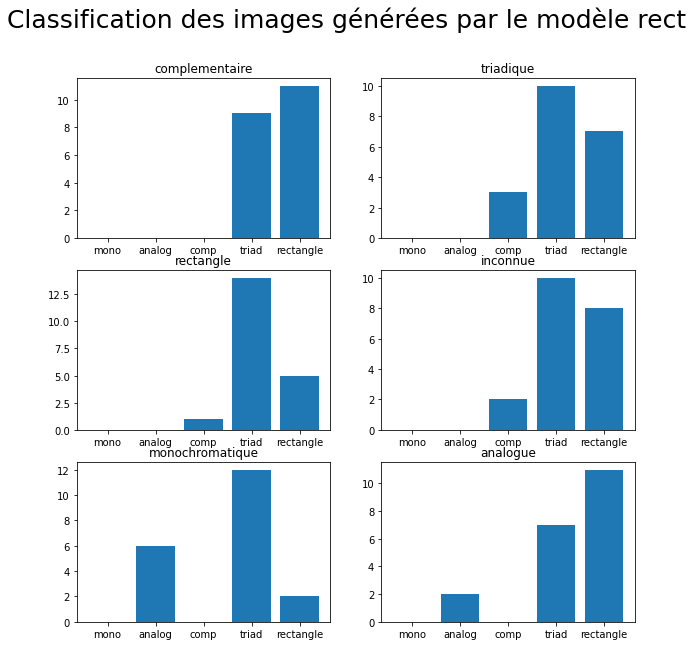

In [36]:
order = ["complementaire","triadique","rectangle","inconnue","monochromatique","analogue"]
plt.figure(figsize=(10,10))
plt.suptitle("Classification des images générées par le modèle "+model_type,fontsize=25)
for i in range(1,7):
  plt.subplot(3,2,i)
  res = allResults[i-1]
  plt.title(order[i-1])
  plt.bar(res.keys(), res.values())